In [12]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [14]:
# Load data
df = pd.read_csv('data.csv')
print(df.shape)
df.head()


(2000, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [15]:
# Target engineering (Diabetic=1, Non-Diabetic=0)
y = df['Outcome'].astype(int)
X = df.drop(columns=['Outcome'])
feature_names_full = X.columns.tolist()
print('Initial features:', len(feature_names_full))
X.head()


Initial features: 8


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,2,138,62,35,0,33.6,0.127,47
1,0,84,82,31,125,38.2,0.233,23
2,0,145,0,0,0,44.2,0.630,31
3,0,135,68,42,250,42.3,0.365,24
4,1,139,62,41,480,40.7,0.536,21


In [22]:
# Train/Test split BEFORE any fitting (prevents leakage)
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(X_train_full.shape, X_test_full.shape)


(1600, 8) (400, 8)


In [23]:
# Correlation-based feature selection using only training data
train_tmp = X_train_full.copy()
train_tmp['Target'] = y_train.values
corr = train_tmp.corr(numeric_only=True)
threshold = 0.1  # Using your threshold
selected_features = [c for c in corr.columns if c != 'Target' and abs(corr.loc[c,'Target']) >= threshold]
if not selected_features:
    selected_features = feature_names_full
print('Selected features (abs corr >=', threshold, '):', len(selected_features))
print(selected_features)

Selected features (abs corr >= 0.1 ): 6
['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


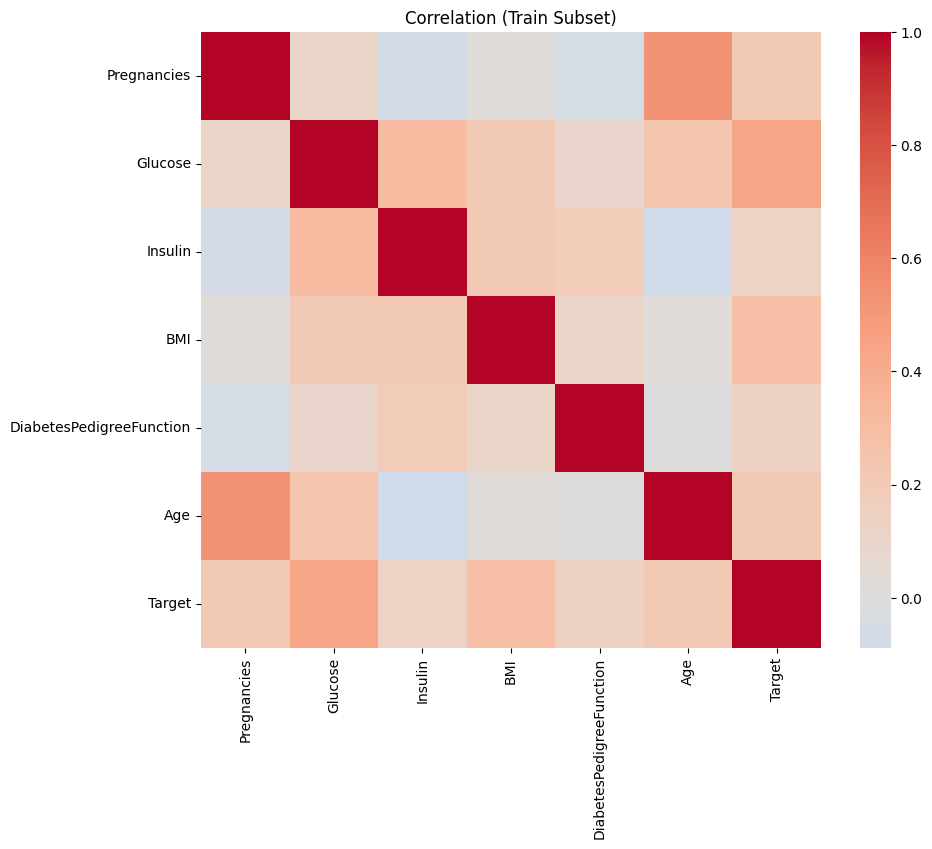

In [25]:
# Quick visualization (optional)
plt.figure(figsize=(10,8))
sns.heatmap(train_df[selected_features + ['Target']].corr(), cmap='coolwarm', center=0)
plt.title('Correlation (Train Subset)')
plt.show()


In [26]:
X_train = X_train_full[selected_features].copy()
X_test = X_test_full[selected_features].copy()
print('Final shapes:', X_train.shape, X_test.shape)


Final shapes: (1600, 6) (400, 6)


In [27]:
def eval_model(name, model, Xtr, Xte, ytr, yte):
    return {
        'model': name,
        'train_acc': accuracy_score(ytr, model.predict(Xtr)),
        'test_acc': accuracy_score(yte, model.predict(Xte))
    }

In [28]:
# SVM Pipeline with GridSearch (Scaling included)
svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())
])

svm_param_grid = [
    {'svc__kernel': ['linear'], 'svc__C': [0.1, 1, 10, 100], 'svc__probability':[True]},
    {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10, 100], 'svc__gamma': ['scale','auto'], 'svc__probability':[True]}
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_grid = GridSearchCV(
    svm_pipe, svm_param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=0
)
svm_grid.fit(X_train, y_train)
print('Best SVM Params:', svm_grid.best_params_)
print('Best CV Accuracy:', round(svm_grid.best_score_,4))
best_svm = svm_grid.best_estimator_


Best SVM Params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf', 'svc__probability': True}
Best CV Accuracy: 0.8756


In [29]:
# Logistic Regression (simple tuned grid)
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=500, random_state=42))
])
lr_params = {
    'lr__C': [0.1,1,10],
    'lr__penalty': ['l2'],
    'lr__solver': ['lbfgs']
}
lr_grid = GridSearchCV(lr_pipe, lr_params, scoring='accuracy', cv=cv, n_jobs=-1)
lr_grid.fit(X_train, y_train)
print('Best LR Params:', lr_grid.best_params_)
best_lr = lr_grid.best_estimator_


Best LR Params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__solver': 'lbfgs'}


In [30]:
# Decision Tree (light tuning)
dt_pipe = Pipeline([
    ('dt', DecisionTreeClassifier(random_state=42))
])
dt_params = {
    'dt__max_depth': [None, 3, 5, 7, 9],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(dt_pipe, dt_params, scoring='accuracy', cv=cv, n_jobs=-1)
dt_grid.fit(X_train, y_train)
print('Best DT Params:', dt_grid.best_params_)
best_dt = dt_grid.best_estimator_


Best DT Params: {'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}


In [31]:
# Random Forest (restricted tuning to keep runtime reasonable)
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
rf_params = {
    'rf__n_estimators': [100, 300],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf_pipe, rf_params, scoring='accuracy', cv=cv, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print('Best RF Params:', rf_grid.best_params_)
best_rf = rf_grid.best_estimator_


Best RF Params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}


In [34]:
# Aggregate performance
results = []
for name, mdl in [
    ('SVM', best_svm),
    ('LogReg', best_lr),
    ('DecisionTree', best_dt),
    ('RandomForest', best_rf)
]:
    res = eval_model(name, mdl, X_train, X_test, y_train, y_test)
    results.append(res)
pd.DataFrame(results)


,model,train_acc,test_acc
0,SVM,0.940625,0.8825
1,LogReg,0.771250,0.8025
2,DecisionTree,1.000000,0.9825
3,RandomForest,1.000000,0.9850


Chosen final model: RandomForest

Classification Report (Test):
              precision    recall  f1-score   support

Non-Diabetic       0.99      0.99      0.99       263
    Diabetic       0.98      0.98      0.98       137

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



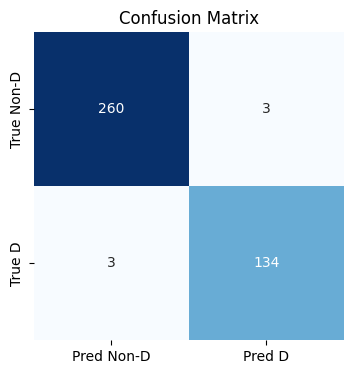

In [35]:
# Pick best by test accuracy (tie -> first)
results_sorted = sorted(results, key=lambda d: d['test_acc'], reverse=True)
best_name = results_sorted[0]['model']
print('Chosen final model:', best_name)

model_map = {
    'SVM': best_svm,
    'LogReg': best_lr,
    'DecisionTree': best_dt,
    'RandomForest': best_rf
}
final_pipeline = model_map[best_name]

# Evaluate in detail
y_pred = final_pipeline.predict(X_test)
print('\nClassification Report (Test):')
print(classification_report(y_test, y_pred, target_names=['Non-Diabetic','Diabetic']))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred Non-D','Pred D'], yticklabels=['True Non-D','True D'])
plt.title('Confusion Matrix')
plt.show()


In [38]:
# Wrap final pipeline as rf_classifier (name preserved for saving)
rf_classifier = final_pipeline  # Keeping variable name as requested

# Save EXACTLY as before (pickle, same filename)
filename = 'diabetes.sav'
with open(filename, 'wb') as f:
    pickle.dump(rf_classifier, f)
print('Saved model to', filename)


Saved model to diabetes.sav


In [39]:
# Optional metadata (not changing model save format/name)
meta = {
  'model_file': 'diabetes.sav',
  'final_model_type': best_name,
  'selected_features': selected_features,
  'all_features_original_order': feature_names_full,
  'best_params': (rf_classifier.named_steps['rf'].get_params() if best_name=='RF' else None),
  'target_mapping': {'0':'Non-Diabetic','1':'Diabetic'},
  'positive_class': 1
}
with open('diabetes_metadata.json','w') as f:
    json.dump(meta, f, indent=2)
print('Metadata saved: diabetes_metadata.json')


Metadata saved: diabetes_metadata.json
